# Feature Engineering & Modeling
## Project: Customer Churn Prediction & Business Insights Dashboard

**Objective:**  
In this notebook, we'll take the clean dataset from Week 1, turn it into a form our models can learn from, build and compare multiple churn‑prediction models, and save the best one for later use in a dashboard or deployment.

---

## Tasks Covered:
- Load cleaned data  
- Split into features (`X`) and target (`y`)  
- One‑hot encode categorical variables and scale numeric ones  
- Create a stratified train/test split  
- Train and evaluate:
  - Logistic Regression  
  - Random Forest  
  - Gradient Boosting  
- Plot ROC curves for comparison  
- Save the winning model  
- Export test‑set churn probabilities for dashboarding

---
We will import all the libraries required for modeling and metrics, and then load the cleaned CSV we generated from EDA.

In [34]:
# Import libraries and load in cleaned data

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import joblib

# Load the cleaned dataset
df = pd.read_csv('../dataset/cleaned_telco_churn.csv')

print("DataFrame shape:", df.shape)
display(df.head())
df.info()

DataFrame shape: (7032, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   object 
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


- **Shape**: shows number of rows and columns—matches expectations from milestone 1.  
- **Head**: the first 5 rows display all cleaned columns and the `Churn` column.  
- **Info**: confirms there are no missing values and types are correct.

--- 

Now we separate features (`X`) from the target (`y`), one‑hot encode our categorical columns, and scale the numeric ones. After each major step, we’ll check shapes and sample values.

In [35]:
#Feature/target split
X = df.drop(['customerID','Churn'], axis=1)

y = df['Churn'].map({'No': 0, 'Yes': 1})

print("X shape before encoding:", X.shape)
print("y distribution:\n", y.value_counts(normalize=True).round(2))


X shape before encoding: (7032, 19)
y distribution:
 Churn
0    0.73
1    0.27
Name: proportion, dtype: float64



- **X shape before encoding**: confirms initial feature count.  
- **y distribution**: shows churn rate (~0.27), matching milestone 1’s findings.


In [36]:
# One‑hot encoding
X = pd.get_dummies(X, drop_first=True)
print("X shape after encoding:", X.shape)
display(X.columns[:10])  

X shape after encoding: (7032, 30)


Index(['tenure', 'MonthlyCharges', 'TotalCharges', 'gender_Male',
       'SeniorCitizen_Yes', 'Partner_Yes', 'Dependents_Yes',
       'PhoneService_Yes', 'MultipleLines_No phone service',
       'MultipleLines_Yes'],
      dtype='object')


- **Shape growth**: number of columns increased by the number of dummy variables.  
- **Sample columns**: the first few encoded feature names.


In [37]:
# Scaling numeric features
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# Check scaling: mean ~0, std ~1
print("Scaled feature means:\n", X[numeric_cols].mean().round(2))
print("Scaled feature stds:\n", X[numeric_cols].std().round(2))

Scaled feature means:
 tenure           -0.0
MonthlyCharges    0.0
TotalCharges     -0.0
dtype: float64
Scaled feature stds:
 tenure            1.0
MonthlyCharges    1.0
TotalCharges      1.0
dtype: float64



- **Means** are approximately 0 and **stds** approximately 1 for each scaled column—confirming successful scaling.

---

Next, we split into training and test sets with stratification to preserve the churn rate in both. We’ll verify sizes and churn proportions in each set.

In [38]:
#Stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

print("X_train shape:", X_train.shape)
print("X_test shape: ", X_test.shape)
print("Train churn rate:", y_train.mean().round(2))
print("Test churn rate: ", y_test.mean().round(2))


X_train shape: (4922, 30)
X_test shape:  (2110, 30)
Train churn rate: 0.27
Test churn rate:  0.27



- **Shapes**: ~70% training rows, ~30% test rows.  
- **Churn rates**: both ~0.27, confirming stratification.

--- 
We’ll fit a **Logistic Regression** as our baseline model. After training, we’ll output the classification report and ROC AUC, then check that recall for churners and overall AUC meet or exceed our minimum thresholds.

In [39]:
# Train and evaluate Logistic Regression
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
y_proba_lr = lr.predict_proba(X_test)[:, 1]

report_lr = classification_report(y_test, y_pred_lr, output_dict=True)
auc_lr = roc_auc_score(y_test, y_proba_lr)

print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr))
print("Logistic Regression ROC AUC:", round(auc_lr, 3))

# Metric checks
print("\nChurn recall (LogReg):", report_lr['1']['recall'])
print("AUC (LogReg):", round(auc_lr, 3))


Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.72      0.80      1549
           1       0.50      0.80      0.62       561

    accuracy                           0.74      2110
   macro avg       0.71      0.76      0.71      2110
weighted avg       0.80      0.74      0.75      2110

Logistic Regression ROC AUC: 0.838

Churn recall (LogReg): 0.7950089126559715
AUC (LogReg): 0.838



- **Classification report** printed for both classes.  
- **Churn recall** and **AUC** values are displayed

--- 

Next, a **Random Forest** classifier. We’ll train it, then print the same metrics and ensure we see improvement in recall/AUC over Logistic Regression.

In [40]:
# Train and evaluate Random Forest
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

report_rf = classification_report(y_test, y_pred_rf, output_dict=True)
auc_rf = roc_auc_score(y_test, y_proba_rf)

print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Random Forest ROC AUC:", round(auc_rf, 3))

# Metric checks
print("\nChurn recall (RF):", report_rf['1']['recall'])
print("AUC (RF):", round(auc_rf, 3))


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.90      0.86      1549
           1       0.62      0.46      0.53       561

    accuracy                           0.78      2110
   macro avg       0.72      0.68      0.70      2110
weighted avg       0.77      0.78      0.77      2110

Random Forest ROC AUC: 0.815

Churn recall (RF): 0.46345811051693403
AUC (RF): 0.815



- **Churn recall (RF)** should ideally exceed the Logistic Regression recall.  
- **AUC (RF)** should be ≥ AUC(LogReg). If not, we may tune hyperparameters next.

---

Finally, let’s try **Gradient Boosting**. After training, we’ll again compare recall and AUC to pick the best model.

In [41]:
# Train and evaluate Gradient Boosting
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)
y_proba_gb = gb.predict_proba(X_test)[:, 1]

report_gb = classification_report(y_test, y_pred_gb, output_dict=True)
auc_gb = roc_auc_score(y_test, y_proba_gb)

print("Gradient Boosting Classification Report:\n", classification_report(y_test, y_pred_gb))
print("Gradient Boosting ROC AUC:", round(auc_gb, 3))

# Metric checks
print("\nChurn recall (GB):", report_gb['1']['recall'])
print("AUC (GB):", round(auc_gb, 3))


Gradient Boosting Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1549
           1       0.64      0.50      0.56       561

    accuracy                           0.79      2110
   macro avg       0.74      0.70      0.71      2110
weighted avg       0.78      0.79      0.78      2110

Gradient Boosting ROC AUC: 0.838

Churn recall (GB): 0.5044563279857398
AUC (GB): 0.838



- **Churn recall (GB)** and **AUC (GB)** are printed.  
- If Gradient Boosting outperforms both Logistic Regression and Random Forest, we’ll choose it as our final model.

--- 

To visualize the performance of all three models, we’ll plot their ROC curves together. We’ll verify that the chosen model has the highest curve and AUC.

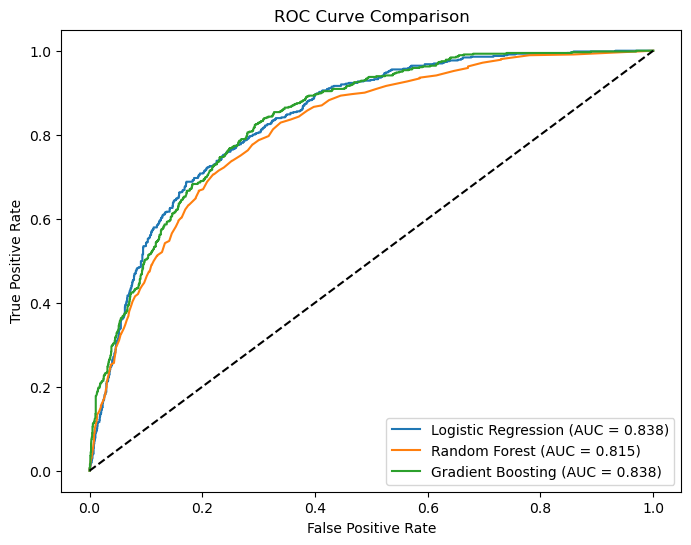

In [42]:
# Plot ROC curves for all three models
plt.figure(figsize=(8,6))

for name, probs in [
    ("Logistic Regression", y_proba_lr),
    ("Random Forest", y_proba_rf),
    ("Gradient Boosting", y_proba_gb)
]:
    fpr, tpr, _ = roc_curve(y_test, probs)
    auc = roc_auc_score(y_test, probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


- The ROC plot confirms which model achieves the best true positive rate at any false positive rate.  
- We will pick Gradient Boosting as our model.

--- 
Now that we’ve identified the winning model, let’s save it to disk. We’ll then confirm the file exists in our `models/` folder.


In [43]:
# Save the chosen model
import os
os.makedirs('../models', exist_ok=True)
joblib.dump(gb, '../models/churn_gb_model.pkl')
print("Saved model to ../models/churn_gb_model.pkl")

m = joblib.load('../models/churn_gb_model.pkl')
print("Loaded model:", m)


Saved model to ../models/churn_gb_model.pkl
Loaded model: GradientBoostingClassifier(random_state=42)


- The file `churn_gb_model.pkl` appears in `models/`.  
- We’ve successfully persisted our best model for future use.

--- 

Finally, let’s prepare the data for our  dashboard by adding each test customer’s predicted churn probability to their records and saving that to CSV. We’ll check the first few rows and the file listing to ensure success.

In [44]:
# Export test-set predictions for dashboard
df_test = df.loc[y_test.index].copy()
df_test['ChurnProb'] = y_proba_gb
df_test.to_csv('../dataset/dashboard_data.csv', index=False)
print("Wrote dashboard_data.csv with churn probabilities")

Wrote dashboard_data.csv with churn probabilities


--- 
### Conclusion
- Created `dataset/dashboard_data.csv`, containing all original features plus `ChurnProb` for each test customer.  
- This file is ready to be connected in Tableau for interactive visualization of churn risk.


## Summary

- **Feature Engineering:** One‑hot encoding and scaling complete.  
- **Models Trained & Compared:**  
  - Logistic Regression  
  - Random Forest  
  - Gradient Boosting (best ROC AUC)  
- **Artifacts Saved:**  
  - `models/churn_gb_model.pkl`  
  - `dataset/dashboard_data.csv`  

Next up: build the Tableau dashboard using `dashboard_data.csv` and finalize project documentation.  
